## Notable links
[GitHub](https://github.com/JoeyShapiro/ITS530-cgan/tree/main)
NOTE: That wgan is my attempt at adding embeddings

### NOTES
[wgan](https://www.youtube.com/watch?v=pG0QZ7OddX4)
### TODO
- scale data better
- add embedder
- add everything here

## Embedder

In [1]:
items = [ 'sword', 'pickaxe', 'axe', 'hoe', 'shovel' ]
mats = [ 'stone', 'diamond', 'iron', 'gold', 'wood', 'netherite' ]
combs = []

for item in items:
    for mat in mats:
        combs.append(f"{mat} {item}")
        combs.append(f"{item} {mat}")

dataset = []
for comb in combs:
    for comb2 in combs:
        text1 = comb.split(' ')
        text2 = comb2.split(' ')
        # if text1[0] == text2[0] and text1[1] == text2[1]:
        #     similarity = 1
        # elif text1[0] == text2[1] and text1[1] != text2[0]:
        #     similarity = 0.5
        # smart
        similarity = 0
        for word in text1:
            if word in text2:
                similarity += 0.5

        dataset.append({ 'texts': (comb, comb2), 'similarity': similarity })
    
display(dataset[:5])
print(len(dataset))

[{'texts': ('stone sword', 'stone sword'), 'similarity': 1.0},
 {'texts': ('stone sword', 'sword stone'), 'similarity': 1.0},
 {'texts': ('stone sword', 'diamond sword'), 'similarity': 0.5},
 {'texts': ('stone sword', 'sword diamond'), 'similarity': 0.5},
 {'texts': ('stone sword', 'iron sword'), 'similarity': 0.5}]

3600


In [2]:
from sentence_transformers import SentenceTransformer, InputExample, losses
from torch.utils.data import DataLoader
import torch.nn as nn
from sentence_transformers import models

word_embedding_model = models.Transformer("bert-base-uncased", max_seq_length=256)
pooling_model = models.Pooling(word_embedding_model.get_word_embedding_dimension())
dense_model = models.Dense(
    in_features=pooling_model.get_sentence_embedding_dimension(),
    out_features=18,
    activation_function=nn.Tanh(),
)

model = SentenceTransformer(modules=[word_embedding_model, pooling_model, dense_model])

train_examples = [
    InputExample(texts=d['texts'], label=d['similarity']) for d in dataset
]
train_dataloader = DataLoader(train_examples, shuffle=True, batch_size=16)
train_loss = losses.CosineSimilarityLoss(model)

# Tune the model
model.fit(train_objectives=[(train_dataloader, train_loss)], epochs=1, warmup_steps=100)

Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Iteration:   0%|          | 0/225 [00:00<?, ?it/s]

In [3]:
from sentence_transformers import util

sentences = ["stone sword", "I'm full of happiness", "wooden sword", "sword stone", "stone pickaxe"]

#Compute embedding for both lists
embedding_1= model.encode(sentences[0], convert_to_tensor=True)
embedding_2 = model.encode(sentences[1], convert_to_tensor=True)
embedding_3 = model.encode(sentences[2], convert_to_tensor=True)
embedding_4 = model.encode(sentences[3], convert_to_tensor=True)
embedding_5 = model.encode(sentences[4], convert_to_tensor=True)

print(embedding_1)
print(embedding_1.shape)
print(embedding_2.shape)
print(f'{sentences[0]} ?= {sentences[1]} =', util.pytorch_cos_sim(embedding_1, embedding_2))
print(f'{sentences[0]} ?= {sentences[2]} =', util.pytorch_cos_sim(embedding_1, embedding_3))
print(f'{sentences[0]} ?= {sentences[3]} =', util.pytorch_cos_sim(embedding_1, embedding_4))
print(f'{sentences[0]} ?= {sentences[4]} =', util.pytorch_cos_sim(embedding_1, embedding_5))
print(model.encode(sentences[0], convert_to_tensor=True))
print(model.encode(sentences[0], convert_to_tensor=True))

tensor([ 0.2215,  0.5099, -0.1680, -0.0275, -0.1095, -0.0127, -0.4784,  0.1671,
         0.0630,  0.5942,  0.2614,  0.2800,  0.3229,  0.6554, -0.0815, -0.3525,
        -0.1435,  0.0976], device='mps:0')
torch.Size([18])
torch.Size([18])
stone sword ?= I'm full of happiness = tensor([[0.3611]], device='mps:0')
stone sword ?= wooden sword = tensor([[0.7109]], device='mps:0')
stone sword ?= sword stone = tensor([[0.9820]], device='mps:0')
stone sword ?= stone pickaxe = tensor([[0.5643]], device='mps:0')
tensor([ 0.2215,  0.5099, -0.1680, -0.0275, -0.1095, -0.0127, -0.4784,  0.1671,
         0.0630,  0.5942,  0.2614,  0.2800,  0.3229,  0.6554, -0.0815, -0.3525,
        -0.1435,  0.0976], device='mps:0')
tensor([ 0.2215,  0.5099, -0.1680, -0.0275, -0.1095, -0.0127, -0.4784,  0.1671,
         0.0630,  0.5942,  0.2614,  0.2800,  0.3229,  0.6554, -0.0815, -0.3525,
        -0.1435,  0.0976], device='mps:0')


In [53]:
embedding_1 = model.encode(sentences[0], convert_to_tensor=True)
embedding_2 = model.encode(sentences[1], convert_to_tensor=True)
print(f'{sentences[0]} ?= {sentences[1]} =', util.pytorch_cos_sim(embedding_1, embedding_2))

embedding_1= (model.encode(sentences[0], convert_to_tensor=True) + 1) / 2
embedding_2 = (model.encode(sentences[1], convert_to_tensor=True) + 1) / 2

print(f'{sentences[0]} ?= {sentences[1]} =', util.pytorch_cos_sim(embedding_1, embedding_2))

stone sword ?= I'm full of happiness = tensor([[0.3611]], device='mps:0')
stone sword ?= I'm full of happiness = tensor([[0.9616]], device='mps:0')


## GAN

In [4]:

import torch
import numpy as np
import os

from torchvision import datasets
from torchvision import transforms
import torchvision.transforms as T

import matplotlib.pyplot as plt
import pandas as pd

from numpy import genfromtxt

from PIL import Image

import random

# import visiondataset
from torchvision.datasets import VisionDataset

In [5]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score

In [6]:

from torch.utils.data import TensorDataset, DataLoader

import torch.optim as optim 
import torch.nn as nn


import torch.nn.functional as F

from torch.autograd import Variable

from fastai.vision.all import *
from fastai.vision.gan import *

from fastai.callback.all import *

In [7]:
from datasets import load_dataset, Split

In [8]:
import torch.autograd as autograd

In [9]:
channels = 3 ## 1 for B&W, 3 for RGB, 4 for RGBA

learning_rate    = 2e-4#0.003  ## Adam default   ## 0.001 2e-4#
batch_size       = 64
N_Epochs         = 1_000#4_000  ##27000  
num_classes = 3
pixels = 32
img_size = pixels*pixels*channels
certainty_repeater = 6# channels**2 - num_classes
print(f"{img_size=}")

if torch.cuda.is_available():
    device = torch.device('cuda')
elif torch.backends.mps is not None:
    device = torch.device('mps')
    os.environ['PYTORCH_ENABLE_MPS_FALLBACK'] = '1'
else:
    device = torch.device('cpu')
    # print a warning that cpu is being used
    print("Warning: Running on CPU. This will be slow.")
print(f"{device=}")
# device = 'cpu' # something didnt work for mps

img_size=3072
device=device(type='mps')


In [10]:
import pickle
from typing import Any, Callable, Dict, List, Optional, Tuple, Union

class MyDataset(VisionDataset):
    classes = [
        'sword',
        'pickaxe',
        'axe',
        'hoe',
        'shovel'
    ]

    def __init__(
        self,
        root: str = "mc-dataset.pkl",
        train: bool = True,
        transform: Optional[Callable] = None,
        target_transform: Optional[Callable] = None,
    ) -> None:
        super().__init__(root, transform=transform, target_transform=target_transform)
        self.train = train  # training set or test set

        self.data, self.targets, self.names = self._load_data()

    def __getitem__(self, index: int) -> Tuple[Any, Any]:
        """
        Args:
            index (int): Index

        Returns:
            tuple: (image, target) where target is index of the target class.
        """
        img, target, name = self.data[index], int(self.targets[index]), self.names[index]

        # doing this so that it is consistent with all other datasets
        # to return a PIL Image
        # img = Image.fromarray(img.numpy().astype(np.uint8))

        if self.transform is not None:
            img = self.transform(img)

        if self.target_transform is not None:
            target = self.target_transform(target)

        return img, target, name

    def __len__(self) -> int:
        return len(self.data)
    
    def _load_data(self):
        with open('mc-dataset.pkl', 'rb') as f:
            data = pickle.load(f)
        
        imgs = []
        labels = []
        names = []
        for i in range(len(data)):
            imgs.append(torch.Tensor(data[i][0]))
            labels.append(data[i][1])
            names.append(data[i][2])

        # if self.train:
        #     data = data[0]
        # else:
        #     data = data[1]
        return imgs, labels, names

img.shape=torch.Size([32, 32, 3]) label=1 name.shape=torch.Size([18])
tensor([0.1440, 0.4295, 0.4584, 0.6453, 0.4134, 0.5527, 0.6948, 0.3193, 0.4091,
        0.7510, 0.5828, 0.2258, 0.4615, 0.3904, 0.5212, 0.4075, 0.5465, 0.2327])


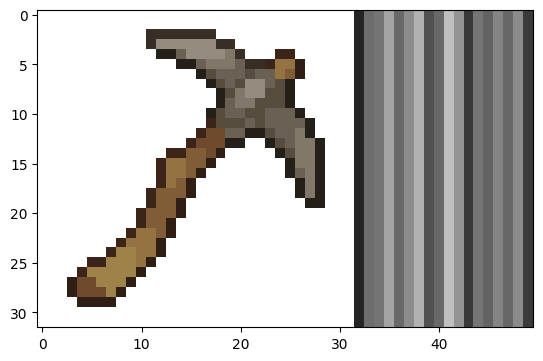

In [44]:
# df = pd.DataFrame(dataset.reshape((dataset.shape[0], 32*32)))
# df.to_csv(f"{data}-dataset.csv", index=False, header=False)

# load the dataset
dataset = MyDataset()

# load the first image in the dataset
# print(dataset[5][0])
img, label, name = dataset[5]
print(f"{img.shape=} {label=} {name.shape=}")
print(name)
img *= 255
name *= 255
name = name.repeat(channels, pixels, 1).permute(1, 2, 0)
img = torch.cat((img, name), dim=1)
plt.imshow(Image.fromarray(img.numpy().astype(np.uint8)))

In [12]:
# display the split of labels in the dataset
for i in range(5):
    print(f"Label {i}: {len([x for x in dataset.targets if x == i])}")

# convert the dataset into a train / test split
# TODO i dont think test is used
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [0.95, 0.05])

# define the dataloader
dl_train = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
dl_test = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

Label 0: 159
Label 1: 123
Label 2: 123
Label 3: 0
Label 4: 0


In [13]:

def plot_GAN_losses(list_losses_fake):
    
    the_epochs = [i for i in range(len(list_losses_fake))]  

    plt.plot(the_epochs, list_losses_fake,    label = "fake") 
    plt.legend() 
    plt.show()


In [14]:

def print_metrics_function(y_test, y_pred):
    print('Accuracy: %.2f' % accuracy_score(y_test, y_pred))
    confmat = confusion_matrix(y_true=y_test, y_pred=y_pred)
    print("Confusion Matrix:")
    print(confmat)
    print('Precision: %.3f' % precision_score(y_true=y_test, y_pred=y_pred, average='weighted'))
    print('Recall: %.3f' % recall_score(y_true=y_test, y_pred=y_pred, average='weighted'))
    f1_measure = f1_score(y_true=y_test, y_pred=y_pred, average='weighted')
    print('F1-mesure: %.3f' % f1_measure)
    return f1_measure, confmat


In [15]:
def plot_metric_per_epoch(the_scores_list):
    x_epochs = []
    y_epochs = [] 
    for i, val in enumerate(the_scores_list):
        x_epochs.append(i)
        y_epochs.append(val)
    
    plt.scatter(x_epochs, y_epochs,s=50,c='lightgreen', marker='s', label='score')
    plt.xlabel('epoch')
    plt.ylabel('score')
    plt.title('Score per epoch')
    plt.legend()
    plt.grid()
    plt.show()

In [16]:
def random_G_vector_input():
    rand_vec = torch.randn( 100 ).to(device)
    return rand_vec

In [17]:
def random_G_batch_vector_input():
    rand_vec = torch.randn( (batch_size, 100 ) ).to(device)
    return rand_vec

In [18]:
def random_batch_one_hot_rc(batch_size, size):
    rand_vec = torch.zeros( (batch_size, num_classes ) ).to(device)
    for i in range(batch_size):
        random_idx = random.randint(0,size-1)
        rand_vec[i, random_idx] = 1.0
    return rand_vec

In [49]:
list_losses_real    = []
list_losses_fake    = []
list_losses_tricked = []

classes = [
    'sword',
    'pickaxe',
    'axe',
    'hoe',
    'shovel'
]

import tqdm

def training_loop(  N_Epochs, G_model, D_model, D_loss_fn, G_opt, D_opt   ):
    pbar = tqdm.tqdm(range(N_Epochs+1))

    for epoch in pbar:
        # shuffle dl_train every epoch
        dl_train = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
        
        for xb, yb, nb in dl_train:              ## xb = [batch, 1, 28, 28]
            xb, yb, nb = xb.to(device), yb.to(device), nb.to(device)

            if xb.shape[0] != batch_size:
                # print(f"skipping batch of size {xb.shape[0]}")
                continue

            if channels == 4 or channels == 3:
                xb = xb.permute(0, 3, 1, 2)
            xb = torch.squeeze(xb, dim=1)
            # TODO how do i deal with this. it was given to 18
            yb = F.one_hot(yb, num_classes=num_classes).repeat(1, certainty_repeater).to(device)
            yb = nb
            print(yb[0])
            # convert nb [batch, 384] to [batch, -1, 32, channels]

            # TODO what is the shape of this. i might be able to just permute the full nb
            yb_certainty = yb.repeat(channels, pixels, 1, 1).permute(2, 0, 1, 3) # [ batch, x (classes), y, channels ]
            # yb_certainty = nb.reshape(batch_size, channels, pixels, -1)
            real = torch.cat( (xb, yb_certainty) , dim=3)

            for _ in range(5):
                noise = torch.cat( (random_G_batch_vector_input(), yb) , dim=1)
                fake = G_model( noise )#.detach()

                real_pred = D_model( real  ).reshape(-1)
                
                inputs = torch.cat( (fake, yb_certainty) , dim=3)
                fake_pred = D_model(  inputs  ).reshape(-1)

                fake_loss   = D_loss_fn(D_model, inputs, real, real_pred, fake_pred)
                # D_opt.zero_grad()
                D_model.zero_grad()
                fake_loss.backward(retain_graph=True)
                D_opt.step()
                
            output = D_model( inputs ).reshape(-1)
            gen_loss = -torch.mean(output)
            G_model.zero_grad()
            gen_loss.backward()
            G_opt.step()
       
            
        if epoch % 10 == 0:
            list_losses_fake.append(        fake_loss.cpu().detach().numpy()  )
            D_fake_loss_rnd = np.round(fake_loss.cpu().detach().numpy(), 3)

            message = f"{D_fake_loss_rnd=}"
            pbar.set_description(message)
            
        # draw an image of each class
        # place them all on the same figure
        if epoch % 100 == 0:
            f, axarr = plt.subplots(nrows=1, ncols=num_classes, figsize=(12,4))
            
            for i in range(num_classes):
                label = torch.tensor([i]).to(device)
                label = F.one_hot(label, num_classes=num_classes)
                label = label.repeat(1, certainty_repeater)

                # create noise and make it 2d
                noise = random_G_vector_input().unsqueeze(0)
                inputs = torch.cat( (noise, label) , dim=1)
                output = G_model( inputs ).cpu()
                # convert output (batch, img_size) to (batch, 4, 32, 32)
                if channels == 4 or channels == 3:
                    # output = output.reshape((-1, 4, pixels, pixels)) # wrong too, lol
                    output = output.reshape((-1, channels, pixels, pixels))
                    # output = output.reshape((-1, 32, 32))

                    img = output.permute(0, 2, 3, 1).detach().numpy()#.reshape(32,32)
                elif channels == 1:
                    img = output.detach().numpy()

                if channels == 4 or channels == 3:
                    mode = None
                elif channels == 1:
                    mode = 'L'

                img = Image.fromarray((img * 255).astype(np.uint8)[0], mode=mode)
                # display the image
                axarr[i].imshow(img)
                # place name of class on image
                axarr[i].set_title(classes[i])
            plt.show()
            


In [20]:
def grad_penatly(critic, real, fake):
    # Random weight term for interpolation between real and fake samples
    batch, c, h, w = real.shape
    epsilon = torch.rand((batch, 1, 1, 1)).repeat(1, c, h, w).to(device)
    interpolated_images = real * epsilon + fake * (1 - epsilon)

    # Calculate critic scores
    mixed_scores = critic(interpolated_images)
    gradient = torch.autograd.grad(
        inputs=interpolated_images,
        outputs=mixed_scores,
        grad_outputs=torch.ones_like(mixed_scores),
        create_graph=True,
        retain_graph=True,
    )[0]

    # Take the norm of the gradient
    gradient = gradient.view(gradient.shape[0], -1)
    grad_norm = gradient.norm(2, dim=1) # L2 norm (euclidean norm)
    gradient_penalty = torch.mean((grad_norm - 1) ** 2)
    return gradient_penalty

In [21]:
def wasserstein_loss(D_model, gen_img, real_data, real_pred, fake_pred):
    loss =  - (real_pred.mean() - fake_pred.mean()) + 10 * grad_penatly(D_model, real_data, gen_img)
    return loss

In [22]:
class Critic(nn.Module):
    def __init__(self, channels_img, features_d):
        super(Critic, self).__init__()
        self.critic = nn.Sequential(
            nn.Conv2d(channels_img, features_d, kernel_size=2, stride=2, padding=1),
            nn.LeakyReLU(0.2),
            self._block(features_d, features_d * 2, 2, 2, 1),
            self._block(features_d * 2, features_d * 4, 2, 2, 1),
            self._block(features_d * 4, features_d * 8, 2, 2, 1),
            nn.Conv2d(features_d * 8, 1, kernel_size=2, stride=2, padding=0),
        )

    def _block(self, in_channels, out_channels, kernel_size, stride, padding):
        return nn.Sequential(
            nn.Conv2d(
                in_channels, out_channels, kernel_size, stride, padding, bias=False
            ),
            nn.InstanceNorm2d(out_channels, affine=True),
            nn.LeakyReLU(0.2),
        )
    
    def forward(self, x):
        return self.critic(x)

  0%|          | 0/1001 [00:00<?, ?it/s]

tensor([0.5389, 0.5704, 0.5417, 0.5059, 0.5803, 0.5180, 0.4314, 0.6701, 0.3137,
        0.4322, 0.5680, 0.5876, 0.5215, 0.4034, 0.4906, 0.4747, 0.6049, 0.5185],
       device='mps:0')
tensor([0.4606, 0.6105, 0.4292, 0.5612, 0.5604, 0.4943, 0.3818, 0.6132, 0.3052,
        0.5286, 0.5458, 0.4616, 0.3783, 0.5159, 0.5156, 0.5393, 0.6700, 0.4155],
       device='mps:0')
tensor([0.4606, 0.6105, 0.4292, 0.5612, 0.5604, 0.4943, 0.3818, 0.6132, 0.3052,
        0.5286, 0.5458, 0.4616, 0.3783, 0.5159, 0.5156, 0.5393, 0.6700, 0.4155],
       device='mps:0')
tensor([0.1440, 0.4295, 0.4584, 0.6453, 0.4134, 0.5527, 0.6948, 0.3193, 0.4091,
        0.7510, 0.5828, 0.2258, 0.4615, 0.3904, 0.5212, 0.4075, 0.5465, 0.2327],
       device='mps:0')
tensor([0.5389, 0.5704, 0.5417, 0.5059, 0.5803, 0.5180, 0.4314, 0.6701, 0.3137,
        0.4322, 0.5680, 0.5876, 0.5215, 0.4034, 0.4906, 0.4747, 0.6049, 0.5185],
       device='mps:0')
tensor([0.2618, 0.3471, 0.3707, 0.4881, 0.4086, 0.4163, 0.4376, 0.5196, 0.2000,


D_fake_loss_rnd=1.906:   0%|          | 0/1001 [00:00<?, ?it/s]/var/folders/8v/kyhpjx6d3y1b7dp0twz_83sw0000gn/T/ipykernel_17776/3791988619.py:101: RuntimeWarning: invalid value encountered in cast
  img = Image.fromarray((img * 255).astype(np.uint8)[0], mode=mode)


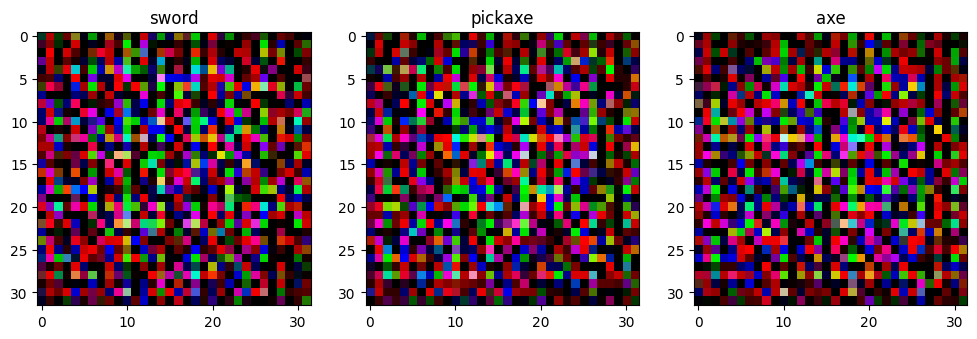

D_fake_loss_rnd=1.906:   0%|          | 1/1001 [00:00<14:40,  1.14it/s]

tensor([0.5389, 0.5704, 0.5417, 0.5059, 0.5803, 0.5180, 0.4314, 0.6701, 0.3137,
        0.4322, 0.5680, 0.5876, 0.5215, 0.4034, 0.4906, 0.4747, 0.6049, 0.5185],
       device='mps:0')
tensor([0.5389, 0.5704, 0.5417, 0.5059, 0.5803, 0.5180, 0.4314, 0.6701, 0.3137,
        0.4322, 0.5680, 0.5876, 0.5215, 0.4034, 0.4906, 0.4747, 0.6049, 0.5185],
       device='mps:0')
tensor([0.3573, 0.5438, 0.4419, 0.6605, 0.5546, 0.7321, 0.3912, 0.6501, 0.3605,
        0.4927, 0.5672, 0.4342, 0.3636, 0.3881, 0.7376, 0.5744, 0.5027, 0.7292],
       device='mps:0')
tensor([0.1439, 0.5874, 0.5731, 0.6635, 0.4935, 0.7038, 0.6067, 0.5829, 0.6530,
        0.5732, 0.6105, 0.1692, 0.2992, 0.3678, 0.6380, 0.4087, 0.6454, 0.6176],
       device='mps:0')
tensor([0.2102, 0.5263, 0.5296, 0.5416, 0.5616, 0.5808, 0.4252, 0.7912, 0.5196,
        0.4536, 0.7706, 0.2790, 0.5050, 0.4269, 0.7060, 0.4864, 0.5019, 0.7146],
       device='mps:0')
tensor([0.5389, 0.5704, 0.5417, 0.5059, 0.5803, 0.5180, 0.4314, 0.6701, 0.3137,


D_fake_loss_rnd=1.906:   0%|          | 2/1001 [00:01<13:10,  1.26it/s]

tensor([0.2102, 0.5263, 0.5296, 0.5416, 0.5616, 0.5808, 0.4252, 0.7912, 0.5196,
        0.4536, 0.7706, 0.2790, 0.5050, 0.4269, 0.7060, 0.4864, 0.5019, 0.7146],
       device='mps:0')
tensor([0.3503, 0.5811, 0.7366, 0.5169, 0.5646, 0.3957, 0.3360, 0.5628, 0.3724,
        0.3026, 0.8325, 0.4773, 0.4635, 0.4828, 0.5091, 0.4382, 0.5580, 0.3658],
       device='mps:0')
tensor([0.1439, 0.5874, 0.5731, 0.6635, 0.4935, 0.7038, 0.6067, 0.5829, 0.6530,
        0.5732, 0.6105, 0.1692, 0.2992, 0.3678, 0.6380, 0.4087, 0.6454, 0.6176],
       device='mps:0')
tensor([0.5389, 0.5704, 0.5417, 0.5059, 0.5803, 0.5180, 0.4314, 0.6701, 0.3137,
        0.4322, 0.5680, 0.5876, 0.5215, 0.4034, 0.4906, 0.4747, 0.6049, 0.5185],
       device='mps:0')
tensor([0.1439, 0.5874, 0.5731, 0.6635, 0.4935, 0.7038, 0.6067, 0.5829, 0.6530,
        0.5732, 0.6105, 0.1692, 0.2992, 0.3678, 0.6380, 0.4087, 0.6454, 0.6176],
       device='mps:0')
tensor([0.5389, 0.5704, 0.5417, 0.5059, 0.5803, 0.5180, 0.4314, 0.6701, 0.3137,


D_fake_loss_rnd=1.906:   0%|          | 3/1001 [00:02<12:36,  1.32it/s]

tensor([0.2694, 0.5717, 0.7109, 0.6172, 0.6328, 0.5256, 0.5620, 0.3303, 0.5168,
        0.4482, 0.7850, 0.4481, 0.2323, 0.4558, 0.3892, 0.3947, 0.7343, 0.3243],
       device='mps:0')
tensor([0.4606, 0.6105, 0.4292, 0.5612, 0.5604, 0.4943, 0.3818, 0.6132, 0.3052,
        0.5286, 0.5458, 0.4616, 0.3783, 0.5159, 0.5156, 0.5393, 0.6700, 0.4155],
       device='mps:0')
tensor([0.3573, 0.5438, 0.4419, 0.6605, 0.5546, 0.7321, 0.3912, 0.6501, 0.3605,
        0.4927, 0.5672, 0.4342, 0.3636, 0.3881, 0.7376, 0.5744, 0.5027, 0.7292],
       device='mps:0')
tensor([0.5389, 0.5704, 0.5417, 0.5059, 0.5803, 0.5180, 0.4314, 0.6701, 0.3137,
        0.4322, 0.5680, 0.5876, 0.5215, 0.4034, 0.4906, 0.4747, 0.6049, 0.5185],
       device='mps:0')
tensor([0.2694, 0.5717, 0.7109, 0.6172, 0.6328, 0.5256, 0.5620, 0.3303, 0.5168,
        0.4482, 0.7850, 0.4481, 0.2323, 0.4558, 0.3892, 0.3947, 0.7343, 0.3243],
       device='mps:0')
tensor([0.3308, 0.4670, 0.6162, 0.4823, 0.5119, 0.4115, 0.4212, 0.5319, 0.4138,


D_fake_loss_rnd=1.906:   0%|          | 4/1001 [00:03<12:14,  1.36it/s]

tensor([0.1440, 0.4295, 0.4584, 0.6453, 0.4134, 0.5527, 0.6948, 0.3193, 0.4091,
        0.7510, 0.5828, 0.2258, 0.4615, 0.3904, 0.5212, 0.4075, 0.5465, 0.2327],
       device='mps:0')
tensor([0.5389, 0.5704, 0.5417, 0.5059, 0.5803, 0.5180, 0.4314, 0.6701, 0.3137,
        0.4322, 0.5680, 0.5876, 0.5215, 0.4034, 0.4906, 0.4747, 0.6049, 0.5185],
       device='mps:0')
tensor([0.5389, 0.5704, 0.5417, 0.5059, 0.5803, 0.5180, 0.4314, 0.6701, 0.3137,
        0.4322, 0.5680, 0.5876, 0.5215, 0.4034, 0.4906, 0.4747, 0.6049, 0.5185],
       device='mps:0')
tensor([0.1440, 0.4295, 0.4584, 0.6453, 0.4134, 0.5527, 0.6948, 0.3193, 0.4091,
        0.7510, 0.5828, 0.2258, 0.4615, 0.3904, 0.5212, 0.4075, 0.5465, 0.2327],
       device='mps:0')
tensor([0.2102, 0.5263, 0.5296, 0.5416, 0.5616, 0.5808, 0.4252, 0.7912, 0.5196,
        0.4536, 0.7706, 0.2790, 0.5050, 0.4269, 0.7060, 0.4864, 0.5019, 0.7146],
       device='mps:0')
tensor([0.3503, 0.5811, 0.7366, 0.5169, 0.5646, 0.3957, 0.3360, 0.5628, 0.3724,


D_fake_loss_rnd=1.906:   0%|          | 5/1001 [00:03<12:00,  1.38it/s]

tensor([0.3573, 0.5438, 0.4419, 0.6605, 0.5546, 0.7321, 0.3912, 0.6501, 0.3605,
        0.4927, 0.5672, 0.4342, 0.3636, 0.3881, 0.7376, 0.5744, 0.5027, 0.7292],
       device='mps:0')
tensor([0.4612, 0.6630, 0.5373, 0.5283, 0.5609, 0.4844, 0.4513, 0.6239, 0.3709,
        0.4475, 0.6223, 0.5930, 0.5527, 0.4313, 0.3900, 0.4316, 0.6447, 0.4944],
       device='mps:0')
tensor([0.3573, 0.5438, 0.4419, 0.6605, 0.5546, 0.7321, 0.3912, 0.6501, 0.3605,
        0.4927, 0.5672, 0.4342, 0.3636, 0.3881, 0.7376, 0.5744, 0.5027, 0.7292],
       device='mps:0')
tensor([0.5389, 0.5704, 0.5417, 0.5059, 0.5803, 0.5180, 0.4314, 0.6701, 0.3137,
        0.4322, 0.5680, 0.5876, 0.5215, 0.4034, 0.4906, 0.4747, 0.6049, 0.5185],
       device='mps:0')
tensor([0.1439, 0.5874, 0.5731, 0.6635, 0.4935, 0.7038, 0.6067, 0.5829, 0.6530,
        0.5732, 0.6105, 0.1692, 0.2992, 0.3678, 0.6380, 0.4087, 0.6454, 0.6176],
       device='mps:0')
tensor([0.3573, 0.5438, 0.4419, 0.6605, 0.5546, 0.7321, 0.3912, 0.6501, 0.3605,


D_fake_loss_rnd=1.906:   1%|          | 6/1001 [00:04<11:52,  1.40it/s]

tensor([0.2694, 0.5717, 0.7109, 0.6172, 0.6328, 0.5256, 0.5620, 0.3303, 0.5168,
        0.4482, 0.7850, 0.4481, 0.2323, 0.4558, 0.3892, 0.3947, 0.7343, 0.3243],
       device='mps:0')
tensor([0.2618, 0.3471, 0.3707, 0.4881, 0.4086, 0.4163, 0.4376, 0.5196, 0.2000,
        0.5820, 0.8209, 0.3195, 0.7360, 0.5404, 0.6242, 0.4631, 0.3310, 0.3142],
       device='mps:0')
tensor([0.4606, 0.6105, 0.4292, 0.5612, 0.5604, 0.4943, 0.3818, 0.6132, 0.3052,
        0.5286, 0.5458, 0.4616, 0.3783, 0.5159, 0.5156, 0.5393, 0.6700, 0.4155],
       device='mps:0')
tensor([0.2420, 0.4608, 0.4817, 0.6300, 0.4954, 0.5939, 0.5616, 0.5107, 0.6117,
        0.6061, 0.6420, 0.2671, 0.3989, 0.3344, 0.6261, 0.5166, 0.7043, 0.6492],
       device='mps:0')
tensor([0.3573, 0.5438, 0.4419, 0.6605, 0.5546, 0.7321, 0.3912, 0.6501, 0.3605,
        0.4927, 0.5672, 0.4342, 0.3636, 0.3881, 0.7376, 0.5744, 0.5027, 0.7292],
       device='mps:0')
tensor([0.5389, 0.5704, 0.5417, 0.5059, 0.5803, 0.5180, 0.4314, 0.6701, 0.3137,


D_fake_loss_rnd=1.906:   1%|          | 7/1001 [00:05<11:51,  1.40it/s]

tensor([0.3573, 0.5438, 0.4419, 0.6605, 0.5546, 0.7321, 0.3912, 0.6501, 0.3605,
        0.4927, 0.5672, 0.4342, 0.3636, 0.3881, 0.7376, 0.5744, 0.5027, 0.7292],
       device='mps:0')
tensor([0.2694, 0.5717, 0.7109, 0.6172, 0.6328, 0.5256, 0.5620, 0.3303, 0.5168,
        0.4482, 0.7850, 0.4481, 0.2323, 0.4558, 0.3892, 0.3947, 0.7343, 0.3243],
       device='mps:0')
tensor([0.4606, 0.6105, 0.4292, 0.5612, 0.5604, 0.4943, 0.3818, 0.6132, 0.3052,
        0.5286, 0.5458, 0.4616, 0.3783, 0.5159, 0.5156, 0.5393, 0.6700, 0.4155],
       device='mps:0')
tensor([0.1439, 0.5874, 0.5731, 0.6635, 0.4935, 0.7038, 0.6067, 0.5829, 0.6530,
        0.5732, 0.6105, 0.1692, 0.2992, 0.3678, 0.6380, 0.4087, 0.6454, 0.6176],
       device='mps:0')
tensor([0.2102, 0.5263, 0.5296, 0.5416, 0.5616, 0.5808, 0.4252, 0.7912, 0.5196,
        0.4536, 0.7706, 0.2790, 0.5050, 0.4269, 0.7060, 0.4864, 0.5019, 0.7146],
       device='mps:0')
tensor([0.5389, 0.5704, 0.5417, 0.5059, 0.5803, 0.5180, 0.4314, 0.6701, 0.3137,


D_fake_loss_rnd=1.906:   1%|          | 8/1001 [00:05<11:49,  1.40it/s]

tensor([0.1440, 0.4295, 0.4584, 0.6453, 0.4134, 0.5527, 0.6948, 0.3193, 0.4091,
        0.7510, 0.5828, 0.2258, 0.4615, 0.3904, 0.5212, 0.4075, 0.5465, 0.2327],
       device='mps:0')
tensor([0.5389, 0.5704, 0.5417, 0.5059, 0.5803, 0.5180, 0.4314, 0.6701, 0.3137,
        0.4322, 0.5680, 0.5876, 0.5215, 0.4034, 0.4906, 0.4747, 0.6049, 0.5185],
       device='mps:0')
tensor([0.1440, 0.4295, 0.4584, 0.6453, 0.4134, 0.5527, 0.6948, 0.3193, 0.4091,
        0.7510, 0.5828, 0.2258, 0.4615, 0.3904, 0.5212, 0.4075, 0.5465, 0.2327],
       device='mps:0')
tensor([0.3573, 0.5438, 0.4419, 0.6605, 0.5546, 0.7321, 0.3912, 0.6501, 0.3605,
        0.4927, 0.5672, 0.4342, 0.3636, 0.3881, 0.7376, 0.5744, 0.5027, 0.7292],
       device='mps:0')
tensor([0.2618, 0.3471, 0.3707, 0.4881, 0.4086, 0.4163, 0.4376, 0.5196, 0.2000,
        0.5820, 0.8209, 0.3195, 0.7360, 0.5404, 0.6242, 0.4631, 0.3310, 0.3142],
       device='mps:0')
tensor([0.1440, 0.4295, 0.4584, 0.6453, 0.4134, 0.5527, 0.6948, 0.3193, 0.4091,


D_fake_loss_rnd=1.906:   1%|          | 9/1001 [00:06<11:45,  1.41it/s]

tensor([0.5389, 0.5704, 0.5417, 0.5059, 0.5803, 0.5180, 0.4314, 0.6701, 0.3137,
        0.4322, 0.5680, 0.5876, 0.5215, 0.4034, 0.4906, 0.4747, 0.6049, 0.5185],
       device='mps:0')
tensor([0.3503, 0.5811, 0.7366, 0.5169, 0.5646, 0.3957, 0.3360, 0.5628, 0.3724,
        0.3026, 0.8325, 0.4773, 0.4635, 0.4828, 0.5091, 0.4382, 0.5580, 0.3658],
       device='mps:0')
tensor([0.2102, 0.5263, 0.5296, 0.5416, 0.5616, 0.5808, 0.4252, 0.7912, 0.5196,
        0.4536, 0.7706, 0.2790, 0.5050, 0.4269, 0.7060, 0.4864, 0.5019, 0.7146],
       device='mps:0')
tensor([0.3503, 0.5811, 0.7366, 0.5169, 0.5646, 0.3957, 0.3360, 0.5628, 0.3724,
        0.3026, 0.8325, 0.4773, 0.4635, 0.4828, 0.5091, 0.4382, 0.5580, 0.3658],
       device='mps:0')
tensor([0.5389, 0.5704, 0.5417, 0.5059, 0.5803, 0.5180, 0.4314, 0.6701, 0.3137,
        0.4322, 0.5680, 0.5876, 0.5215, 0.4034, 0.4906, 0.4747, 0.6049, 0.5185],
       device='mps:0')
tensor([0.2618, 0.3471, 0.3707, 0.4881, 0.4086, 0.4163, 0.4376, 0.5196, 0.2000,


D_fake_loss_rnd=1.906:   1%|          | 10/1001 [00:07<11:40,  1.42it/s]

tensor([0.2618, 0.3471, 0.3707, 0.4881, 0.4086, 0.4163, 0.4376, 0.5196, 0.2000,
        0.5820, 0.8209, 0.3195, 0.7360, 0.5404, 0.6242, 0.4631, 0.3310, 0.3142],
       device='mps:0')
tensor([0.3503, 0.5811, 0.7366, 0.5169, 0.5646, 0.3957, 0.3360, 0.5628, 0.3724,
        0.3026, 0.8325, 0.4773, 0.4635, 0.4828, 0.5091, 0.4382, 0.5580, 0.3658],
       device='mps:0')
tensor([0.5389, 0.5704, 0.5417, 0.5059, 0.5803, 0.5180, 0.4314, 0.6701, 0.3137,
        0.4322, 0.5680, 0.5876, 0.5215, 0.4034, 0.4906, 0.4747, 0.6049, 0.5185],
       device='mps:0')
tensor([0.1440, 0.4295, 0.4584, 0.6453, 0.4134, 0.5527, 0.6948, 0.3193, 0.4091,
        0.7510, 0.5828, 0.2258, 0.4615, 0.3904, 0.5212, 0.4075, 0.5465, 0.2327],
       device='mps:0')
tensor([0.1439, 0.5874, 0.5731, 0.6635, 0.4935, 0.7038, 0.6067, 0.5829, 0.6530,
        0.5732, 0.6105, 0.1692, 0.2992, 0.3678, 0.6380, 0.4087, 0.6454, 0.6176],
       device='mps:0')
tensor([0.2694, 0.5717, 0.7109, 0.6172, 0.6328, 0.5256, 0.5620, 0.3303, 0.5168,


D_fake_loss_rnd=-71.122:   1%|          | 11/1001 [00:07<11:36,  1.42it/s]

tensor([0.1440, 0.4295, 0.4584, 0.6453, 0.4134, 0.5527, 0.6948, 0.3193, 0.4091,
        0.7510, 0.5828, 0.2258, 0.4615, 0.3904, 0.5212, 0.4075, 0.5465, 0.2327],
       device='mps:0')
tensor([0.4612, 0.6630, 0.5373, 0.5283, 0.5609, 0.4844, 0.4513, 0.6239, 0.3709,
        0.4475, 0.6223, 0.5930, 0.5527, 0.4313, 0.3900, 0.4316, 0.6447, 0.4944],
       device='mps:0')
tensor([0.3308, 0.4670, 0.6162, 0.4823, 0.5119, 0.4115, 0.4212, 0.5319, 0.4138,
        0.4051, 0.8079, 0.5057, 0.5065, 0.4519, 0.5160, 0.4808, 0.6416, 0.4520],
       device='mps:0')
tensor([0.4606, 0.6105, 0.4292, 0.5612, 0.5604, 0.4943, 0.3818, 0.6132, 0.3052,
        0.5286, 0.5458, 0.4616, 0.3783, 0.5159, 0.5156, 0.5393, 0.6700, 0.4155],
       device='mps:0')
tensor([0.3573, 0.5438, 0.4419, 0.6605, 0.5546, 0.7321, 0.3912, 0.6501, 0.3605,
        0.4927, 0.5672, 0.4342, 0.3636, 0.3881, 0.7376, 0.5744, 0.5027, 0.7292],
       device='mps:0')
tensor([0.4606, 0.6105, 0.4292, 0.5612, 0.5604, 0.4943, 0.3818, 0.6132, 0.3052,


D_fake_loss_rnd=-71.122:   1%|          | 12/1001 [00:08<11:39,  1.41it/s]

tensor([0.2618, 0.3471, 0.3707, 0.4881, 0.4086, 0.4163, 0.4376, 0.5196, 0.2000,
        0.5820, 0.8209, 0.3195, 0.7360, 0.5404, 0.6242, 0.4631, 0.3310, 0.3142],
       device='mps:0')
tensor([0.4606, 0.6105, 0.4292, 0.5612, 0.5604, 0.4943, 0.3818, 0.6132, 0.3052,
        0.5286, 0.5458, 0.4616, 0.3783, 0.5159, 0.5156, 0.5393, 0.6700, 0.4155],
       device='mps:0')
tensor([0.1440, 0.4295, 0.4584, 0.6453, 0.4134, 0.5527, 0.6948, 0.3193, 0.4091,
        0.7510, 0.5828, 0.2258, 0.4615, 0.3904, 0.5212, 0.4075, 0.5465, 0.2327],
       device='mps:0')
tensor([0.1439, 0.5874, 0.5731, 0.6635, 0.4935, 0.7038, 0.6067, 0.5829, 0.6530,
        0.5732, 0.6105, 0.1692, 0.2992, 0.3678, 0.6380, 0.4087, 0.6454, 0.6176],
       device='mps:0')
tensor([0.3573, 0.5438, 0.4419, 0.6605, 0.5546, 0.7321, 0.3912, 0.6501, 0.3605,
        0.4927, 0.5672, 0.4342, 0.3636, 0.3881, 0.7376, 0.5744, 0.5027, 0.7292],
       device='mps:0')
tensor([0.3716, 0.5362, 0.6663, 0.5211, 0.5347, 0.3577, 0.3968, 0.5411, 0.3835,


D_fake_loss_rnd=-71.122:   1%|▏         | 13/1001 [00:09<11:43,  1.41it/s]

tensor([0.2618, 0.3471, 0.3707, 0.4881, 0.4086, 0.4163, 0.4376, 0.5196, 0.2000,
        0.5820, 0.8209, 0.3195, 0.7360, 0.5404, 0.6242, 0.4631, 0.3310, 0.3142],
       device='mps:0')
tensor([0.1440, 0.4295, 0.4584, 0.6453, 0.4134, 0.5527, 0.6948, 0.3193, 0.4091,
        0.7510, 0.5828, 0.2258, 0.4615, 0.3904, 0.5212, 0.4075, 0.5465, 0.2327],
       device='mps:0')
tensor([0.2420, 0.4608, 0.4817, 0.6300, 0.4954, 0.5939, 0.5616, 0.5107, 0.6117,
        0.6061, 0.6420, 0.2671, 0.3989, 0.3344, 0.6261, 0.5166, 0.7043, 0.6492],
       device='mps:0')
tensor([0.4606, 0.6105, 0.4292, 0.5612, 0.5604, 0.4943, 0.3818, 0.6132, 0.3052,
        0.5286, 0.5458, 0.4616, 0.3783, 0.5159, 0.5156, 0.5393, 0.6700, 0.4155],
       device='mps:0')
tensor([0.3573, 0.5438, 0.4419, 0.6605, 0.5546, 0.7321, 0.3912, 0.6501, 0.3605,
        0.4927, 0.5672, 0.4342, 0.3636, 0.3881, 0.7376, 0.5744, 0.5027, 0.7292],
       device='mps:0')
tensor([0.5389, 0.5704, 0.5417, 0.5059, 0.5803, 0.5180, 0.4314, 0.6701, 0.3137,


D_fake_loss_rnd=-71.122:   1%|▏         | 14/1001 [00:10<11:44,  1.40it/s]

tensor([0.2618, 0.3471, 0.3707, 0.4881, 0.4086, 0.4163, 0.4376, 0.5196, 0.2000,
        0.5820, 0.8209, 0.3195, 0.7360, 0.5404, 0.6242, 0.4631, 0.3310, 0.3142],
       device='mps:0')
tensor([0.4606, 0.6105, 0.4292, 0.5612, 0.5604, 0.4943, 0.3818, 0.6132, 0.3052,
        0.5286, 0.5458, 0.4616, 0.3783, 0.5159, 0.5156, 0.5393, 0.6700, 0.4155],
       device='mps:0')
tensor([0.5389, 0.5704, 0.5417, 0.5059, 0.5803, 0.5180, 0.4314, 0.6701, 0.3137,
        0.4322, 0.5680, 0.5876, 0.5215, 0.4034, 0.4906, 0.4747, 0.6049, 0.5185],
       device='mps:0')
tensor([0.2102, 0.5263, 0.5296, 0.5416, 0.5616, 0.5808, 0.4252, 0.7912, 0.5196,
        0.4536, 0.7706, 0.2790, 0.5050, 0.4269, 0.7060, 0.4864, 0.5019, 0.7146],
       device='mps:0')
tensor([0.4606, 0.6105, 0.4292, 0.5612, 0.5604, 0.4943, 0.3818, 0.6132, 0.3052,
        0.5286, 0.5458, 0.4616, 0.3783, 0.5159, 0.5156, 0.5393, 0.6700, 0.4155],
       device='mps:0')
tensor([0.5389, 0.5704, 0.5417, 0.5059, 0.5803, 0.5180, 0.4314, 0.6701, 0.3137,


D_fake_loss_rnd=-71.122:   1%|▏         | 15/1001 [00:10<11:41,  1.41it/s]

tensor([0.4606, 0.6105, 0.4292, 0.5612, 0.5604, 0.4943, 0.3818, 0.6132, 0.3052,
        0.5286, 0.5458, 0.4616, 0.3783, 0.5159, 0.5156, 0.5393, 0.6700, 0.4155],
       device='mps:0')
tensor([0.1439, 0.5874, 0.5731, 0.6635, 0.4935, 0.7038, 0.6067, 0.5829, 0.6530,
        0.5732, 0.6105, 0.1692, 0.2992, 0.3678, 0.6380, 0.4087, 0.6454, 0.6176],
       device='mps:0')
tensor([0.5389, 0.5704, 0.5417, 0.5059, 0.5803, 0.5180, 0.4314, 0.6701, 0.3137,
        0.4322, 0.5680, 0.5876, 0.5215, 0.4034, 0.4906, 0.4747, 0.6049, 0.5185],
       device='mps:0')
tensor([0.3573, 0.5438, 0.4419, 0.6605, 0.5546, 0.7321, 0.3912, 0.6501, 0.3605,
        0.4927, 0.5672, 0.4342, 0.3636, 0.3881, 0.7376, 0.5744, 0.5027, 0.7292],
       device='mps:0')
tensor([0.2694, 0.5717, 0.7109, 0.6172, 0.6328, 0.5256, 0.5620, 0.3303, 0.5168,
        0.4482, 0.7850, 0.4481, 0.2323, 0.4558, 0.3892, 0.3947, 0.7343, 0.3243],
       device='mps:0')
tensor([0.2045, 0.3933, 0.4165, 0.6088, 0.4200, 0.5464, 0.6344, 0.3566, 0.4192,


D_fake_loss_rnd=-71.122:   2%|▏         | 16/1001 [00:11<11:39,  1.41it/s]

tensor([0.3573, 0.5438, 0.4419, 0.6605, 0.5546, 0.7321, 0.3912, 0.6501, 0.3605,
        0.4927, 0.5672, 0.4342, 0.3636, 0.3881, 0.7376, 0.5744, 0.5027, 0.7292],
       device='mps:0')
tensor([0.3573, 0.5438, 0.4419, 0.6605, 0.5546, 0.7321, 0.3912, 0.6501, 0.3605,
        0.4927, 0.5672, 0.4342, 0.3636, 0.3881, 0.7376, 0.5744, 0.5027, 0.7292],
       device='mps:0')
tensor([0.4606, 0.6105, 0.4292, 0.5612, 0.5604, 0.4943, 0.3818, 0.6132, 0.3052,
        0.5286, 0.5458, 0.4616, 0.3783, 0.5159, 0.5156, 0.5393, 0.6700, 0.4155],
       device='mps:0')
tensor([0.4606, 0.6105, 0.4292, 0.5612, 0.5604, 0.4943, 0.3818, 0.6132, 0.3052,
        0.5286, 0.5458, 0.4616, 0.3783, 0.5159, 0.5156, 0.5393, 0.6700, 0.4155],
       device='mps:0')
tensor([0.4606, 0.6105, 0.4292, 0.5612, 0.5604, 0.4943, 0.3818, 0.6132, 0.3052,
        0.5286, 0.5458, 0.4616, 0.3783, 0.5159, 0.5156, 0.5393, 0.6700, 0.4155],
       device='mps:0')
tensor([0.1440, 0.4295, 0.4584, 0.6453, 0.4134, 0.5527, 0.6948, 0.3193, 0.4091,


D_fake_loss_rnd=-71.122:   2%|▏         | 17/1001 [00:12<11:34,  1.42it/s]

tensor([0.5389, 0.5704, 0.5417, 0.5059, 0.5803, 0.5180, 0.4314, 0.6701, 0.3137,
        0.4322, 0.5680, 0.5876, 0.5215, 0.4034, 0.4906, 0.4747, 0.6049, 0.5185],
       device='mps:0')
tensor([0.4606, 0.6105, 0.4292, 0.5612, 0.5604, 0.4943, 0.3818, 0.6132, 0.3052,
        0.5286, 0.5458, 0.4616, 0.3783, 0.5159, 0.5156, 0.5393, 0.6700, 0.4155],
       device='mps:0')
tensor([0.3503, 0.5811, 0.7366, 0.5169, 0.5646, 0.3957, 0.3360, 0.5628, 0.3724,
        0.3026, 0.8325, 0.4773, 0.4635, 0.4828, 0.5091, 0.4382, 0.5580, 0.3658],
       device='mps:0')
tensor([0.1439, 0.5874, 0.5731, 0.6635, 0.4935, 0.7038, 0.6067, 0.5829, 0.6530,
        0.5732, 0.6105, 0.1692, 0.2992, 0.3678, 0.6380, 0.4087, 0.6454, 0.6176],
       device='mps:0')
tensor([0.2694, 0.5717, 0.7109, 0.6172, 0.6328, 0.5256, 0.5620, 0.3303, 0.5168,
        0.4482, 0.7850, 0.4481, 0.2323, 0.4558, 0.3892, 0.3947, 0.7343, 0.3243],
       device='mps:0')
tensor([0.4606, 0.6105, 0.4292, 0.5612, 0.5604, 0.4943, 0.3818, 0.6132, 0.3052,


D_fake_loss_rnd=-71.122:   2%|▏         | 18/1001 [00:12<11:30,  1.42it/s]

tensor([0.1439, 0.5874, 0.5731, 0.6635, 0.4935, 0.7038, 0.6067, 0.5829, 0.6530,
        0.5732, 0.6105, 0.1692, 0.2992, 0.3678, 0.6380, 0.4087, 0.6454, 0.6176],
       device='mps:0')
tensor([0.4606, 0.6105, 0.4292, 0.5612, 0.5604, 0.4943, 0.3818, 0.6132, 0.3052,
        0.5286, 0.5458, 0.4616, 0.3783, 0.5159, 0.5156, 0.5393, 0.6700, 0.4155],
       device='mps:0')
tensor([0.4606, 0.6105, 0.4292, 0.5612, 0.5604, 0.4943, 0.3818, 0.6132, 0.3052,
        0.5286, 0.5458, 0.4616, 0.3783, 0.5159, 0.5156, 0.5393, 0.6700, 0.4155],
       device='mps:0')
tensor([0.2413, 0.3190, 0.3755, 0.5096, 0.3877, 0.4460, 0.4459, 0.5227, 0.2966,
        0.5789, 0.7653, 0.3640, 0.7176, 0.4638, 0.6109, 0.4773, 0.4766, 0.3467],
       device='mps:0')
tensor([0.2694, 0.5717, 0.7109, 0.6172, 0.6328, 0.5256, 0.5620, 0.3303, 0.5168,
        0.4482, 0.7850, 0.4481, 0.2323, 0.4558, 0.3892, 0.3947, 0.7343, 0.3243],
       device='mps:0')
tensor([0.4612, 0.6630, 0.5373, 0.5283, 0.5609, 0.4844, 0.4513, 0.6239, 0.3709,


D_fake_loss_rnd=-71.122:   2%|▏         | 19/1001 [00:13<11:28,  1.43it/s]

tensor([0.1440, 0.4295, 0.4584, 0.6453, 0.4134, 0.5527, 0.6948, 0.3193, 0.4091,
        0.7510, 0.5828, 0.2258, 0.4615, 0.3904, 0.5212, 0.4075, 0.5465, 0.2327],
       device='mps:0')
tensor([0.2694, 0.5717, 0.7109, 0.6172, 0.6328, 0.5256, 0.5620, 0.3303, 0.5168,
        0.4482, 0.7850, 0.4481, 0.2323, 0.4558, 0.3892, 0.3947, 0.7343, 0.3243],
       device='mps:0')
tensor([0.3573, 0.5438, 0.4419, 0.6605, 0.5546, 0.7321, 0.3912, 0.6501, 0.3605,
        0.4927, 0.5672, 0.4342, 0.3636, 0.3881, 0.7376, 0.5744, 0.5027, 0.7292],
       device='mps:0')
tensor([0.3573, 0.5438, 0.4419, 0.6605, 0.5546, 0.7321, 0.3912, 0.6501, 0.3605,
        0.4927, 0.5672, 0.4342, 0.3636, 0.3881, 0.7376, 0.5744, 0.5027, 0.7292],
       device='mps:0')
tensor([0.3573, 0.5438, 0.4419, 0.6605, 0.5546, 0.7321, 0.3912, 0.6501, 0.3605,
        0.4927, 0.5672, 0.4342, 0.3636, 0.3881, 0.7376, 0.5744, 0.5027, 0.7292],
       device='mps:0')
tensor([0.2618, 0.3471, 0.3707, 0.4881, 0.4086, 0.4163, 0.4376, 0.5196, 0.2000,


D_fake_loss_rnd=-71.122:   2%|▏         | 20/1001 [00:14<11:27,  1.43it/s]

tensor([0.4606, 0.6105, 0.4292, 0.5612, 0.5604, 0.4943, 0.3818, 0.6132, 0.3052,
        0.5286, 0.5458, 0.4616, 0.3783, 0.5159, 0.5156, 0.5393, 0.6700, 0.4155],
       device='mps:0')
tensor([0.2694, 0.5717, 0.7109, 0.6172, 0.6328, 0.5256, 0.5620, 0.3303, 0.5168,
        0.4482, 0.7850, 0.4481, 0.2323, 0.4558, 0.3892, 0.3947, 0.7343, 0.3243],
       device='mps:0')
tensor([0.1440, 0.4295, 0.4584, 0.6453, 0.4134, 0.5527, 0.6948, 0.3193, 0.4091,
        0.7510, 0.5828, 0.2258, 0.4615, 0.3904, 0.5212, 0.4075, 0.5465, 0.2327],
       device='mps:0')
tensor([0.1440, 0.4295, 0.4584, 0.6453, 0.4134, 0.5527, 0.6948, 0.3193, 0.4091,
        0.7510, 0.5828, 0.2258, 0.4615, 0.3904, 0.5212, 0.4075, 0.5465, 0.2327],
       device='mps:0')
tensor([0.5389, 0.5704, 0.5417, 0.5059, 0.5803, 0.5180, 0.4314, 0.6701, 0.3137,
        0.4322, 0.5680, 0.5876, 0.5215, 0.4034, 0.4906, 0.4747, 0.6049, 0.5185],
       device='mps:0')
tensor([0.2618, 0.3471, 0.3707, 0.4881, 0.4086, 0.4163, 0.4376, 0.5196, 0.2000,


D_fake_loss_rnd=-103.517:   2%|▏         | 21/1001 [00:15<11:27,  1.43it/s]

tensor([0.5389, 0.5704, 0.5417, 0.5059, 0.5803, 0.5180, 0.4314, 0.6701, 0.3137,
        0.4322, 0.5680, 0.5876, 0.5215, 0.4034, 0.4906, 0.4747, 0.6049, 0.5185],
       device='mps:0')
tensor([0.6481, 0.6045, 0.4457, 0.4687, 0.5367, 0.4834, 0.4615, 0.5177, 0.3141,
        0.3604, 0.6778, 0.5540, 0.4486, 0.3124, 0.5632, 0.4627, 0.7179, 0.5082],
       device='mps:0')
tensor([0.1440, 0.4295, 0.4584, 0.6453, 0.4134, 0.5527, 0.6948, 0.3193, 0.4091,
        0.7510, 0.5828, 0.2258, 0.4615, 0.3904, 0.5212, 0.4075, 0.5465, 0.2327],
       device='mps:0')
tensor([0.2618, 0.3471, 0.3707, 0.4881, 0.4086, 0.4163, 0.4376, 0.5196, 0.2000,
        0.5820, 0.8209, 0.3195, 0.7360, 0.5404, 0.6242, 0.4631, 0.3310, 0.3142],
       device='mps:0')
tensor([0.2102, 0.5263, 0.5296, 0.5416, 0.5616, 0.5808, 0.4252, 0.7912, 0.5196,
        0.4536, 0.7706, 0.2790, 0.5050, 0.4269, 0.7060, 0.4864, 0.5019, 0.7146],
       device='mps:0')
tensor([0.1440, 0.4295, 0.4584, 0.6453, 0.4134, 0.5527, 0.6948, 0.3193, 0.4091,


D_fake_loss_rnd=-103.517:   2%|▏         | 22/1001 [00:15<11:26,  1.43it/s]

tensor([0.4606, 0.6105, 0.4292, 0.5612, 0.5604, 0.4943, 0.3818, 0.6132, 0.3052,
        0.5286, 0.5458, 0.4616, 0.3783, 0.5159, 0.5156, 0.5393, 0.6700, 0.4155],
       device='mps:0')
tensor([0.6481, 0.6045, 0.4457, 0.4687, 0.5367, 0.4834, 0.4615, 0.5177, 0.3141,
        0.3604, 0.6778, 0.5540, 0.4486, 0.3124, 0.5632, 0.4627, 0.7179, 0.5082],
       device='mps:0')
tensor([0.3503, 0.5811, 0.7366, 0.5169, 0.5646, 0.3957, 0.3360, 0.5628, 0.3724,
        0.3026, 0.8325, 0.4773, 0.4635, 0.4828, 0.5091, 0.4382, 0.5580, 0.3658],
       device='mps:0')
tensor([0.5389, 0.5704, 0.5417, 0.5059, 0.5803, 0.5180, 0.4314, 0.6701, 0.3137,
        0.4322, 0.5680, 0.5876, 0.5215, 0.4034, 0.4906, 0.4747, 0.6049, 0.5185],
       device='mps:0')
tensor([0.1439, 0.5874, 0.5731, 0.6635, 0.4935, 0.7038, 0.6067, 0.5829, 0.6530,
        0.5732, 0.6105, 0.1692, 0.2992, 0.3678, 0.6380, 0.4087, 0.6454, 0.6176],
       device='mps:0')
tensor([0.4606, 0.6105, 0.4292, 0.5612, 0.5604, 0.4943, 0.3818, 0.6132, 0.3052,


D_fake_loss_rnd=-103.517:   2%|▏         | 23/1001 [00:16<11:25,  1.43it/s]

tensor([0.3573, 0.5438, 0.4419, 0.6605, 0.5546, 0.7321, 0.3912, 0.6501, 0.3605,
        0.4927, 0.5672, 0.4342, 0.3636, 0.3881, 0.7376, 0.5744, 0.5027, 0.7292],
       device='mps:0')
tensor([0.1440, 0.4295, 0.4584, 0.6453, 0.4134, 0.5527, 0.6948, 0.3193, 0.4091,
        0.7510, 0.5828, 0.2258, 0.4615, 0.3904, 0.5212, 0.4075, 0.5465, 0.2327],
       device='mps:0')
tensor([0.1440, 0.4295, 0.4584, 0.6453, 0.4134, 0.5527, 0.6948, 0.3193, 0.4091,
        0.7510, 0.5828, 0.2258, 0.4615, 0.3904, 0.5212, 0.4075, 0.5465, 0.2327],
       device='mps:0')
tensor([0.2618, 0.3471, 0.3707, 0.4881, 0.4086, 0.4163, 0.4376, 0.5196, 0.2000,
        0.5820, 0.8209, 0.3195, 0.7360, 0.5404, 0.6242, 0.4631, 0.3310, 0.3142],
       device='mps:0')
tensor([0.4606, 0.6105, 0.4292, 0.5612, 0.5604, 0.4943, 0.3818, 0.6132, 0.3052,
        0.5286, 0.5458, 0.4616, 0.3783, 0.5159, 0.5156, 0.5393, 0.6700, 0.4155],
       device='mps:0')
tensor([0.3573, 0.5438, 0.4419, 0.6605, 0.5546, 0.7321, 0.3912, 0.6501, 0.3605,


D_fake_loss_rnd=-103.517:   2%|▏         | 24/1001 [00:17<11:24,  1.43it/s]

tensor([0.5389, 0.5704, 0.5417, 0.5059, 0.5803, 0.5180, 0.4314, 0.6701, 0.3137,
        0.4322, 0.5680, 0.5876, 0.5215, 0.4034, 0.4906, 0.4747, 0.6049, 0.5185],
       device='mps:0')
tensor([0.1440, 0.4295, 0.4584, 0.6453, 0.4134, 0.5527, 0.6948, 0.3193, 0.4091,
        0.7510, 0.5828, 0.2258, 0.4615, 0.3904, 0.5212, 0.4075, 0.5465, 0.2327],
       device='mps:0')
tensor([0.4612, 0.6630, 0.5373, 0.5283, 0.5609, 0.4844, 0.4513, 0.6239, 0.3709,
        0.4475, 0.6223, 0.5930, 0.5527, 0.4313, 0.3900, 0.4316, 0.6447, 0.4944],
       device='mps:0')
tensor([0.5046, 0.5175, 0.5759, 0.4446, 0.5211, 0.4392, 0.4315, 0.6459, 0.2944,
        0.3978, 0.5308, 0.3681, 0.4715, 0.4341, 0.5321, 0.4625, 0.5684, 0.5185],
       device='mps:0')
tensor([0.2694, 0.5717, 0.7109, 0.6172, 0.6328, 0.5256, 0.5620, 0.3303, 0.5168,
        0.4482, 0.7850, 0.4481, 0.2323, 0.4558, 0.3892, 0.3947, 0.7343, 0.3243],
       device='mps:0')
tensor([0.4612, 0.6630, 0.5373, 0.5283, 0.5609, 0.4844, 0.4513, 0.6239, 0.3709,


D_fake_loss_rnd=-103.517:   2%|▏         | 25/1001 [00:17<11:22,  1.43it/s]

tensor([0.3573, 0.5438, 0.4419, 0.6605, 0.5546, 0.7321, 0.3912, 0.6501, 0.3605,
        0.4927, 0.5672, 0.4342, 0.3636, 0.3881, 0.7376, 0.5744, 0.5027, 0.7292],
       device='mps:0')
tensor([0.4116, 0.5403, 0.6589, 0.5174, 0.5464, 0.3661, 0.4163, 0.5089, 0.4081,
        0.3731, 0.7920, 0.5138, 0.4355, 0.4775, 0.4865, 0.4659, 0.6040, 0.3900],
       device='mps:0')
tensor([0.4606, 0.6105, 0.4292, 0.5612, 0.5604, 0.4943, 0.3818, 0.6132, 0.3052,
        0.5286, 0.5458, 0.4616, 0.3783, 0.5159, 0.5156, 0.5393, 0.6700, 0.4155],
       device='mps:0')
tensor([0.4612, 0.6630, 0.5373, 0.5283, 0.5609, 0.4844, 0.4513, 0.6239, 0.3709,
        0.4475, 0.6223, 0.5930, 0.5527, 0.4313, 0.3900, 0.4316, 0.6447, 0.4944],
       device='mps:0')
tensor([0.3573, 0.5438, 0.4419, 0.6605, 0.5546, 0.7321, 0.3912, 0.6501, 0.3605,
        0.4927, 0.5672, 0.4342, 0.3636, 0.3881, 0.7376, 0.5744, 0.5027, 0.7292],
       device='mps:0')
tensor([0.3573, 0.5438, 0.4419, 0.6605, 0.5546, 0.7321, 0.3912, 0.6501, 0.3605,


D_fake_loss_rnd=-103.517:   3%|▎         | 26/1001 [00:18<11:21,  1.43it/s]

tensor([0.4606, 0.6105, 0.4292, 0.5612, 0.5604, 0.4943, 0.3818, 0.6132, 0.3052,
        0.5286, 0.5458, 0.4616, 0.3783, 0.5159, 0.5156, 0.5393, 0.6700, 0.4155],
       device='mps:0')
tensor([0.3503, 0.5811, 0.7366, 0.5169, 0.5646, 0.3957, 0.3360, 0.5628, 0.3724,
        0.3026, 0.8325, 0.4773, 0.4635, 0.4828, 0.5091, 0.4382, 0.5580, 0.3658],
       device='mps:0')
tensor([0.1440, 0.4295, 0.4584, 0.6453, 0.4134, 0.5527, 0.6948, 0.3193, 0.4091,
        0.7510, 0.5828, 0.2258, 0.4615, 0.3904, 0.5212, 0.4075, 0.5465, 0.2327],
       device='mps:0')
tensor([0.2618, 0.3471, 0.3707, 0.4881, 0.4086, 0.4163, 0.4376, 0.5196, 0.2000,
        0.5820, 0.8209, 0.3195, 0.7360, 0.5404, 0.6242, 0.4631, 0.3310, 0.3142],
       device='mps:0')
tensor([0.1439, 0.5874, 0.5731, 0.6635, 0.4935, 0.7038, 0.6067, 0.5829, 0.6530,
        0.5732, 0.6105, 0.1692, 0.2992, 0.3678, 0.6380, 0.4087, 0.6454, 0.6176],
       device='mps:0')
tensor([0.1439, 0.5874, 0.5731, 0.6635, 0.4935, 0.7038, 0.6067, 0.5829, 0.6530,


D_fake_loss_rnd=-103.517:   3%|▎         | 27/1001 [00:19<11:20,  1.43it/s]

tensor([0.5389, 0.5704, 0.5417, 0.5059, 0.5803, 0.5180, 0.4314, 0.6701, 0.3137,
        0.4322, 0.5680, 0.5876, 0.5215, 0.4034, 0.4906, 0.4747, 0.6049, 0.5185],
       device='mps:0')
tensor([0.2102, 0.5263, 0.5296, 0.5416, 0.5616, 0.5808, 0.4252, 0.7912, 0.5196,
        0.4536, 0.7706, 0.2790, 0.5050, 0.4269, 0.7060, 0.4864, 0.5019, 0.7146],
       device='mps:0')
tensor([0.2102, 0.5263, 0.5296, 0.5416, 0.5616, 0.5808, 0.4252, 0.7912, 0.5196,
        0.4536, 0.7706, 0.2790, 0.5050, 0.4269, 0.7060, 0.4864, 0.5019, 0.7146],
       device='mps:0')
tensor([0.2102, 0.5263, 0.5296, 0.5416, 0.5616, 0.5808, 0.4252, 0.7912, 0.5196,
        0.4536, 0.7706, 0.2790, 0.5050, 0.4269, 0.7060, 0.4864, 0.5019, 0.7146],
       device='mps:0')
tensor([0.5389, 0.5704, 0.5417, 0.5059, 0.5803, 0.5180, 0.4314, 0.6701, 0.3137,
        0.4322, 0.5680, 0.5876, 0.5215, 0.4034, 0.4906, 0.4747, 0.6049, 0.5185],
       device='mps:0')
tensor([0.6481, 0.6045, 0.4457, 0.4687, 0.5367, 0.4834, 0.4615, 0.5177, 0.3141,


D_fake_loss_rnd=-103.517:   3%|▎         | 28/1001 [00:19<11:19,  1.43it/s]

tensor([0.2102, 0.5263, 0.5296, 0.5416, 0.5616, 0.5808, 0.4252, 0.7912, 0.5196,
        0.4536, 0.7706, 0.2790, 0.5050, 0.4269, 0.7060, 0.4864, 0.5019, 0.7146],
       device='mps:0')
tensor([0.6481, 0.6045, 0.4457, 0.4687, 0.5367, 0.4834, 0.4615, 0.5177, 0.3141,
        0.3604, 0.6778, 0.5540, 0.4486, 0.3124, 0.5632, 0.4627, 0.7179, 0.5082],
       device='mps:0')
tensor([0.5389, 0.5704, 0.5417, 0.5059, 0.5803, 0.5180, 0.4314, 0.6701, 0.3137,
        0.4322, 0.5680, 0.5876, 0.5215, 0.4034, 0.4906, 0.4747, 0.6049, 0.5185],
       device='mps:0')
tensor([0.2694, 0.5717, 0.7109, 0.6172, 0.6328, 0.5256, 0.5620, 0.3303, 0.5168,
        0.4482, 0.7850, 0.4481, 0.2323, 0.4558, 0.3892, 0.3947, 0.7343, 0.3243],
       device='mps:0')
tensor([0.1439, 0.5874, 0.5731, 0.6635, 0.4935, 0.7038, 0.6067, 0.5829, 0.6530,
        0.5732, 0.6105, 0.1692, 0.2992, 0.3678, 0.6380, 0.4087, 0.6454, 0.6176],
       device='mps:0')
tensor([0.3573, 0.5438, 0.4419, 0.6605, 0.5546, 0.7321, 0.3912, 0.6501, 0.3605,


D_fake_loss_rnd=-103.517:   3%|▎         | 29/1001 [00:20<11:18,  1.43it/s]

tensor([0.1440, 0.4295, 0.4584, 0.6453, 0.4134, 0.5527, 0.6948, 0.3193, 0.4091,
        0.7510, 0.5828, 0.2258, 0.4615, 0.3904, 0.5212, 0.4075, 0.5465, 0.2327],
       device='mps:0')
tensor([0.4612, 0.6630, 0.5373, 0.5283, 0.5609, 0.4844, 0.4513, 0.6239, 0.3709,
        0.4475, 0.6223, 0.5930, 0.5527, 0.4313, 0.3900, 0.4316, 0.6447, 0.4944],
       device='mps:0')
tensor([0.3503, 0.5811, 0.7366, 0.5169, 0.5646, 0.3957, 0.3360, 0.5628, 0.3724,
        0.3026, 0.8325, 0.4773, 0.4635, 0.4828, 0.5091, 0.4382, 0.5580, 0.3658],
       device='mps:0')
tensor([0.1440, 0.4295, 0.4584, 0.6453, 0.4134, 0.5527, 0.6948, 0.3193, 0.4091,
        0.7510, 0.5828, 0.2258, 0.4615, 0.3904, 0.5212, 0.4075, 0.5465, 0.2327],
       device='mps:0')
tensor([0.3573, 0.5438, 0.4419, 0.6605, 0.5546, 0.7321, 0.3912, 0.6501, 0.3605,
        0.4927, 0.5672, 0.4342, 0.3636, 0.3881, 0.7376, 0.5744, 0.5027, 0.7292],
       device='mps:0')
tensor([0.1440, 0.4295, 0.4584, 0.6453, 0.4134, 0.5527, 0.6948, 0.3193, 0.4091,


D_fake_loss_rnd=-103.517:   3%|▎         | 30/1001 [00:21<11:19,  1.43it/s]

tensor([0.5389, 0.5704, 0.5417, 0.5059, 0.5803, 0.5180, 0.4314, 0.6701, 0.3137,
        0.4322, 0.5680, 0.5876, 0.5215, 0.4034, 0.4906, 0.4747, 0.6049, 0.5185],
       device='mps:0')
tensor([0.5389, 0.5704, 0.5417, 0.5059, 0.5803, 0.5180, 0.4314, 0.6701, 0.3137,
        0.4322, 0.5680, 0.5876, 0.5215, 0.4034, 0.4906, 0.4747, 0.6049, 0.5185],
       device='mps:0')
tensor([0.2618, 0.3471, 0.3707, 0.4881, 0.4086, 0.4163, 0.4376, 0.5196, 0.2000,
        0.5820, 0.8209, 0.3195, 0.7360, 0.5404, 0.6242, 0.4631, 0.3310, 0.3142],
       device='mps:0')
tensor([0.2694, 0.5717, 0.7109, 0.6172, 0.6328, 0.5256, 0.5620, 0.3303, 0.5168,
        0.4482, 0.7850, 0.4481, 0.2323, 0.4558, 0.3892, 0.3947, 0.7343, 0.3243],
       device='mps:0')
tensor([0.1439, 0.5874, 0.5731, 0.6635, 0.4935, 0.7038, 0.6067, 0.5829, 0.6530,
        0.5732, 0.6105, 0.1692, 0.2992, 0.3678, 0.6380, 0.4087, 0.6454, 0.6176],
       device='mps:0')
tensor([0.4606, 0.6105, 0.4292, 0.5612, 0.5604, 0.4943, 0.3818, 0.6132, 0.3052,


D_fake_loss_rnd=48.106:   3%|▎         | 31/1001 [00:22<11:19,  1.43it/s]  

tensor([0.3573, 0.5438, 0.4419, 0.6605, 0.5546, 0.7321, 0.3912, 0.6501, 0.3605,
        0.4927, 0.5672, 0.4342, 0.3636, 0.3881, 0.7376, 0.5744, 0.5027, 0.7292],
       device='mps:0')
tensor([0.3573, 0.5438, 0.4419, 0.6605, 0.5546, 0.7321, 0.3912, 0.6501, 0.3605,
        0.4927, 0.5672, 0.4342, 0.3636, 0.3881, 0.7376, 0.5744, 0.5027, 0.7292],
       device='mps:0')
tensor([0.3573, 0.5438, 0.4419, 0.6605, 0.5546, 0.7321, 0.3912, 0.6501, 0.3605,
        0.4927, 0.5672, 0.4342, 0.3636, 0.3881, 0.7376, 0.5744, 0.5027, 0.7292],
       device='mps:0')
tensor([0.4606, 0.6105, 0.4292, 0.5612, 0.5604, 0.4943, 0.3818, 0.6132, 0.3052,
        0.5286, 0.5458, 0.4616, 0.3783, 0.5159, 0.5156, 0.5393, 0.6700, 0.4155],
       device='mps:0')
tensor([0.5389, 0.5704, 0.5417, 0.5059, 0.5803, 0.5180, 0.4314, 0.6701, 0.3137,
        0.4322, 0.5680, 0.5876, 0.5215, 0.4034, 0.4906, 0.4747, 0.6049, 0.5185],
       device='mps:0')
tensor([0.5389, 0.5704, 0.5417, 0.5059, 0.5803, 0.5180, 0.4314, 0.6701, 0.3137,


D_fake_loss_rnd=48.106:   3%|▎         | 32/1001 [00:22<11:18,  1.43it/s]

tensor([0.4606, 0.6105, 0.4292, 0.5612, 0.5604, 0.4943, 0.3818, 0.6132, 0.3052,
        0.5286, 0.5458, 0.4616, 0.3783, 0.5159, 0.5156, 0.5393, 0.6700, 0.4155],
       device='mps:0')
tensor([0.2618, 0.3471, 0.3707, 0.4881, 0.4086, 0.4163, 0.4376, 0.5196, 0.2000,
        0.5820, 0.8209, 0.3195, 0.7360, 0.5404, 0.6242, 0.4631, 0.3310, 0.3142],
       device='mps:0')
tensor([0.3573, 0.5438, 0.4419, 0.6605, 0.5546, 0.7321, 0.3912, 0.6501, 0.3605,
        0.4927, 0.5672, 0.4342, 0.3636, 0.3881, 0.7376, 0.5744, 0.5027, 0.7292],
       device='mps:0')
tensor([0.3573, 0.5438, 0.4419, 0.6605, 0.5546, 0.7321, 0.3912, 0.6501, 0.3605,
        0.4927, 0.5672, 0.4342, 0.3636, 0.3881, 0.7376, 0.5744, 0.5027, 0.7292],
       device='mps:0')
tensor([0.1439, 0.5874, 0.5731, 0.6635, 0.4935, 0.7038, 0.6067, 0.5829, 0.6530,
        0.5732, 0.6105, 0.1692, 0.2992, 0.3678, 0.6380, 0.4087, 0.6454, 0.6176],
       device='mps:0')
tensor([0.3573, 0.5438, 0.4419, 0.6605, 0.5546, 0.7321, 0.3912, 0.6501, 0.3605,


D_fake_loss_rnd=48.106:   3%|▎         | 33/1001 [00:23<11:17,  1.43it/s]

tensor([0.5389, 0.5704, 0.5417, 0.5059, 0.5803, 0.5180, 0.4314, 0.6701, 0.3137,
        0.4322, 0.5680, 0.5876, 0.5215, 0.4034, 0.4906, 0.4747, 0.6049, 0.5185],
       device='mps:0')
tensor([0.2694, 0.5717, 0.7109, 0.6172, 0.6328, 0.5256, 0.5620, 0.3303, 0.5168,
        0.4482, 0.7850, 0.4481, 0.2323, 0.4558, 0.3892, 0.3947, 0.7343, 0.3243],
       device='mps:0')
tensor([0.1440, 0.4295, 0.4584, 0.6453, 0.4134, 0.5527, 0.6948, 0.3193, 0.4091,
        0.7510, 0.5828, 0.2258, 0.4615, 0.3904, 0.5212, 0.4075, 0.5465, 0.2327],
       device='mps:0')
tensor([0.4606, 0.6105, 0.4292, 0.5612, 0.5604, 0.4943, 0.3818, 0.6132, 0.3052,
        0.5286, 0.5458, 0.4616, 0.3783, 0.5159, 0.5156, 0.5393, 0.6700, 0.4155],
       device='mps:0')
tensor([0.1439, 0.5874, 0.5731, 0.6635, 0.4935, 0.7038, 0.6067, 0.5829, 0.6530,
        0.5732, 0.6105, 0.1692, 0.2992, 0.3678, 0.6380, 0.4087, 0.6454, 0.6176],
       device='mps:0')
tensor([0.2694, 0.5717, 0.7109, 0.6172, 0.6328, 0.5256, 0.5620, 0.3303, 0.5168,


D_fake_loss_rnd=48.106:   3%|▎         | 34/1001 [00:24<11:15,  1.43it/s]

tensor([0.5389, 0.5704, 0.5417, 0.5059, 0.5803, 0.5180, 0.4314, 0.6701, 0.3137,
        0.4322, 0.5680, 0.5876, 0.5215, 0.4034, 0.4906, 0.4747, 0.6049, 0.5185],
       device='mps:0')
tensor([0.3573, 0.5438, 0.4419, 0.6605, 0.5546, 0.7321, 0.3912, 0.6501, 0.3605,
        0.4927, 0.5672, 0.4342, 0.3636, 0.3881, 0.7376, 0.5744, 0.5027, 0.7292],
       device='mps:0')
tensor([0.5389, 0.5704, 0.5417, 0.5059, 0.5803, 0.5180, 0.4314, 0.6701, 0.3137,
        0.4322, 0.5680, 0.5876, 0.5215, 0.4034, 0.4906, 0.4747, 0.6049, 0.5185],
       device='mps:0')
tensor([0.3573, 0.5438, 0.4419, 0.6605, 0.5546, 0.7321, 0.3912, 0.6501, 0.3605,
        0.4927, 0.5672, 0.4342, 0.3636, 0.3881, 0.7376, 0.5744, 0.5027, 0.7292],
       device='mps:0')
tensor([0.5389, 0.5704, 0.5417, 0.5059, 0.5803, 0.5180, 0.4314, 0.6701, 0.3137,
        0.4322, 0.5680, 0.5876, 0.5215, 0.4034, 0.4906, 0.4747, 0.6049, 0.5185],
       device='mps:0')
tensor([0.4612, 0.6630, 0.5373, 0.5283, 0.5609, 0.4844, 0.4513, 0.6239, 0.3709,


D_fake_loss_rnd=48.106:   3%|▎         | 35/1001 [00:24<11:13,  1.43it/s]

tensor([0.5389, 0.5704, 0.5417, 0.5059, 0.5803, 0.5180, 0.4314, 0.6701, 0.3137,
        0.4322, 0.5680, 0.5876, 0.5215, 0.4034, 0.4906, 0.4747, 0.6049, 0.5185],
       device='mps:0')
tensor([0.1440, 0.4295, 0.4584, 0.6453, 0.4134, 0.5527, 0.6948, 0.3193, 0.4091,
        0.7510, 0.5828, 0.2258, 0.4615, 0.3904, 0.5212, 0.4075, 0.5465, 0.2327],
       device='mps:0')
tensor([0.5389, 0.5704, 0.5417, 0.5059, 0.5803, 0.5180, 0.4314, 0.6701, 0.3137,
        0.4322, 0.5680, 0.5876, 0.5215, 0.4034, 0.4906, 0.4747, 0.6049, 0.5185],
       device='mps:0')
tensor([0.3573, 0.5438, 0.4419, 0.6605, 0.5546, 0.7321, 0.3912, 0.6501, 0.3605,
        0.4927, 0.5672, 0.4342, 0.3636, 0.3881, 0.7376, 0.5744, 0.5027, 0.7292],
       device='mps:0')
tensor([0.1439, 0.5874, 0.5731, 0.6635, 0.4935, 0.7038, 0.6067, 0.5829, 0.6530,
        0.5732, 0.6105, 0.1692, 0.2992, 0.3678, 0.6380, 0.4087, 0.6454, 0.6176],
       device='mps:0')
tensor([0.3503, 0.5811, 0.7366, 0.5169, 0.5646, 0.3957, 0.3360, 0.5628, 0.3724,


D_fake_loss_rnd=48.106:   4%|▎         | 36/1001 [00:25<11:16,  1.43it/s]

tensor([0.1439, 0.5874, 0.5731, 0.6635, 0.4935, 0.7038, 0.6067, 0.5829, 0.6530,
        0.5732, 0.6105, 0.1692, 0.2992, 0.3678, 0.6380, 0.4087, 0.6454, 0.6176],
       device='mps:0')
tensor([0.2618, 0.3471, 0.3707, 0.4881, 0.4086, 0.4163, 0.4376, 0.5196, 0.2000,
        0.5820, 0.8209, 0.3195, 0.7360, 0.5404, 0.6242, 0.4631, 0.3310, 0.3142],
       device='mps:0')
tensor([0.1440, 0.4295, 0.4584, 0.6453, 0.4134, 0.5527, 0.6948, 0.3193, 0.4091,
        0.7510, 0.5828, 0.2258, 0.4615, 0.3904, 0.5212, 0.4075, 0.5465, 0.2327],
       device='mps:0')
tensor([0.3573, 0.5438, 0.4419, 0.6605, 0.5546, 0.7321, 0.3912, 0.6501, 0.3605,
        0.4927, 0.5672, 0.4342, 0.3636, 0.3881, 0.7376, 0.5744, 0.5027, 0.7292],
       device='mps:0')
tensor([0.6481, 0.6045, 0.4457, 0.4687, 0.5367, 0.4834, 0.4615, 0.5177, 0.3141,
        0.3604, 0.6778, 0.5540, 0.4486, 0.3124, 0.5632, 0.4627, 0.7179, 0.5082],
       device='mps:0')
tensor([0.5389, 0.5704, 0.5417, 0.5059, 0.5803, 0.5180, 0.4314, 0.6701, 0.3137,


D_fake_loss_rnd=48.106:   4%|▎         | 37/1001 [00:26<11:20,  1.42it/s]

tensor([0.2618, 0.3471, 0.3707, 0.4881, 0.4086, 0.4163, 0.4376, 0.5196, 0.2000,
        0.5820, 0.8209, 0.3195, 0.7360, 0.5404, 0.6242, 0.4631, 0.3310, 0.3142],
       device='mps:0')
tensor([0.4606, 0.6105, 0.4292, 0.5612, 0.5604, 0.4943, 0.3818, 0.6132, 0.3052,
        0.5286, 0.5458, 0.4616, 0.3783, 0.5159, 0.5156, 0.5393, 0.6700, 0.4155],
       device='mps:0')
tensor([0.3573, 0.5438, 0.4419, 0.6605, 0.5546, 0.7321, 0.3912, 0.6501, 0.3605,
        0.4927, 0.5672, 0.4342, 0.3636, 0.3881, 0.7376, 0.5744, 0.5027, 0.7292],
       device='mps:0')
tensor([0.3503, 0.5811, 0.7366, 0.5169, 0.5646, 0.3957, 0.3360, 0.5628, 0.3724,
        0.3026, 0.8325, 0.4773, 0.4635, 0.4828, 0.5091, 0.4382, 0.5580, 0.3658],
       device='mps:0')
tensor([0.4612, 0.6630, 0.5373, 0.5283, 0.5609, 0.4844, 0.4513, 0.6239, 0.3709,
        0.4475, 0.6223, 0.5930, 0.5527, 0.4313, 0.3900, 0.4316, 0.6447, 0.4944],
       device='mps:0')
tensor([0.1439, 0.5874, 0.5731, 0.6635, 0.4935, 0.7038, 0.6067, 0.5829, 0.6530,


D_fake_loss_rnd=48.106:   4%|▍         | 38/1001 [00:26<11:24,  1.41it/s]

tensor([0.2694, 0.5717, 0.7109, 0.6172, 0.6328, 0.5256, 0.5620, 0.3303, 0.5168,
        0.4482, 0.7850, 0.4481, 0.2323, 0.4558, 0.3892, 0.3947, 0.7343, 0.3243],
       device='mps:0')
tensor([0.3573, 0.5438, 0.4419, 0.6605, 0.5546, 0.7321, 0.3912, 0.6501, 0.3605,
        0.4927, 0.5672, 0.4342, 0.3636, 0.3881, 0.7376, 0.5744, 0.5027, 0.7292],
       device='mps:0')
tensor([0.3503, 0.5811, 0.7366, 0.5169, 0.5646, 0.3957, 0.3360, 0.5628, 0.3724,
        0.3026, 0.8325, 0.4773, 0.4635, 0.4828, 0.5091, 0.4382, 0.5580, 0.3658],
       device='mps:0')
tensor([0.4606, 0.6105, 0.4292, 0.5612, 0.5604, 0.4943, 0.3818, 0.6132, 0.3052,
        0.5286, 0.5458, 0.4616, 0.3783, 0.5159, 0.5156, 0.5393, 0.6700, 0.4155],
       device='mps:0')
tensor([0.5389, 0.5704, 0.5417, 0.5059, 0.5803, 0.5180, 0.4314, 0.6701, 0.3137,
        0.4322, 0.5680, 0.5876, 0.5215, 0.4034, 0.4906, 0.4747, 0.6049, 0.5185],
       device='mps:0')
tensor([0.3573, 0.5438, 0.4419, 0.6605, 0.5546, 0.7321, 0.3912, 0.6501, 0.3605,


D_fake_loss_rnd=48.106:   4%|▍         | 39/1001 [00:27<11:26,  1.40it/s]

tensor([0.5389, 0.5704, 0.5417, 0.5059, 0.5803, 0.5180, 0.4314, 0.6701, 0.3137,
        0.4322, 0.5680, 0.5876, 0.5215, 0.4034, 0.4906, 0.4747, 0.6049, 0.5185],
       device='mps:0')
tensor([0.4606, 0.6105, 0.4292, 0.5612, 0.5604, 0.4943, 0.3818, 0.6132, 0.3052,
        0.5286, 0.5458, 0.4616, 0.3783, 0.5159, 0.5156, 0.5393, 0.6700, 0.4155],
       device='mps:0')
tensor([0.3573, 0.5438, 0.4419, 0.6605, 0.5546, 0.7321, 0.3912, 0.6501, 0.3605,
        0.4927, 0.5672, 0.4342, 0.3636, 0.3881, 0.7376, 0.5744, 0.5027, 0.7292],
       device='mps:0')
tensor([0.1439, 0.5874, 0.5731, 0.6635, 0.4935, 0.7038, 0.6067, 0.5829, 0.6530,
        0.5732, 0.6105, 0.1692, 0.2992, 0.3678, 0.6380, 0.4087, 0.6454, 0.6176],
       device='mps:0')


D_fake_loss_rnd=48.106:   4%|▍         | 39/1001 [00:28<11:33,  1.39it/s]


KeyboardInterrupt: 

In [50]:
G_model     =  basic_generator(pixels, in_sz=100+num_classes*certainty_repeater, n_channels=channels, n_extra_layers=1)# Generator_Net()

# G_model     = Generator_DL_Net()

D_model     =    basic_critic(
                    pixels, 
                    n_channels=channels, 
                    n_extra_layers=1, 
                    act_cls=partial(  nn.LeakyReLU, negative_slope=0.2)
)#

D_model     = Critic(channels_img=channels, features_d=pixels)

# D_model = CriticNet()

## D_loss_fn   = nn.CrossEntropyLoss( )  
## D_loss_fn   = F.mse_loss

D_loss_fn = wasserstein_loss
# use a loss function that supports values between -1 and 1
# D_loss_fn = nn.BCEWithLogitsLoss()

G_opt       = torch.optim.Adam( G_model.parameters(), lr=learning_rate, betas=(0.0, 0.9) )
D_opt       = torch.optim.Adam( D_model.parameters(), lr=learning_rate, betas=(0.0, 0.9) )

# move everything to device
G_model.to(device)
D_model.to(device)
# D_loss_fn.to(device)

training_loop(  N_Epochs, G_model, D_model, D_loss_fn, G_opt, D_opt )


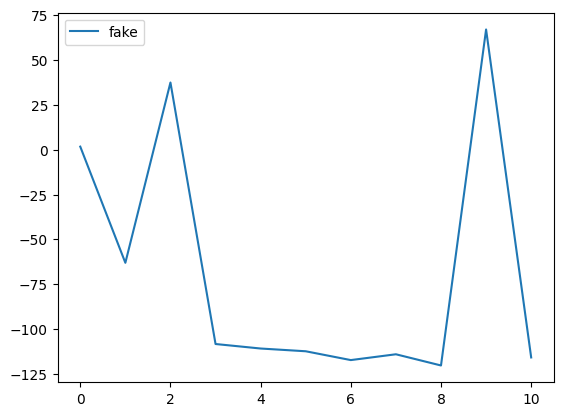

In [24]:
plot_GAN_losses(list_losses_fake)

In [25]:
label = 0
        
label_tensor = torch.zeros((num_classes)).to(device)
label_tensor[label] = 1.0

label_tensor = label_tensor.unsqueeze(0)
label_tensor = label_tensor.repeat(1, certainty_repeater)
print(label_tensor.shape)

# label_tensor = label_tensor.repeat(4, 32, 1).permute(0, 1, 2)
# label_tensor.shape

torch.Size([1, 18])


In [26]:
from sentence_transformers import SentenceTransformer, util

# model = SentenceTransformer('sentence-transformers/all-MiniLM-L6-v2')

#Compute embedding for both lists
embedding = model.encode('stone sword', convert_to_tensor=True)
embedding = (embedding + 1) / 2
# compressor = nn.Linear(384, 18).to('mps')
# label_tensor = (compressor(embedding)).unsqueeze(0).to(device)
label_tensor = embedding.unsqueeze(0)#.reshape(1, channels, pixels, -1)
print(label_tensor.shape)
print(label_tensor)

torch.Size([1, 18])
tensor([[0.6108, 0.7549, 0.4160, 0.4863, 0.4453, 0.4937, 0.2608, 0.5836, 0.5315,
         0.7971, 0.6307, 0.6400, 0.6615, 0.8277, 0.4592, 0.3237, 0.4282, 0.5488]],
       device='mps:0')


/var/folders/8v/kyhpjx6d3y1b7dp0twz_83sw0000gn/T/ipykernel_17776/2723397247.py:20: RuntimeWarning: invalid value encountered in cast
  img = Image.fromarray((img * 255).astype(np.uint8)[0])


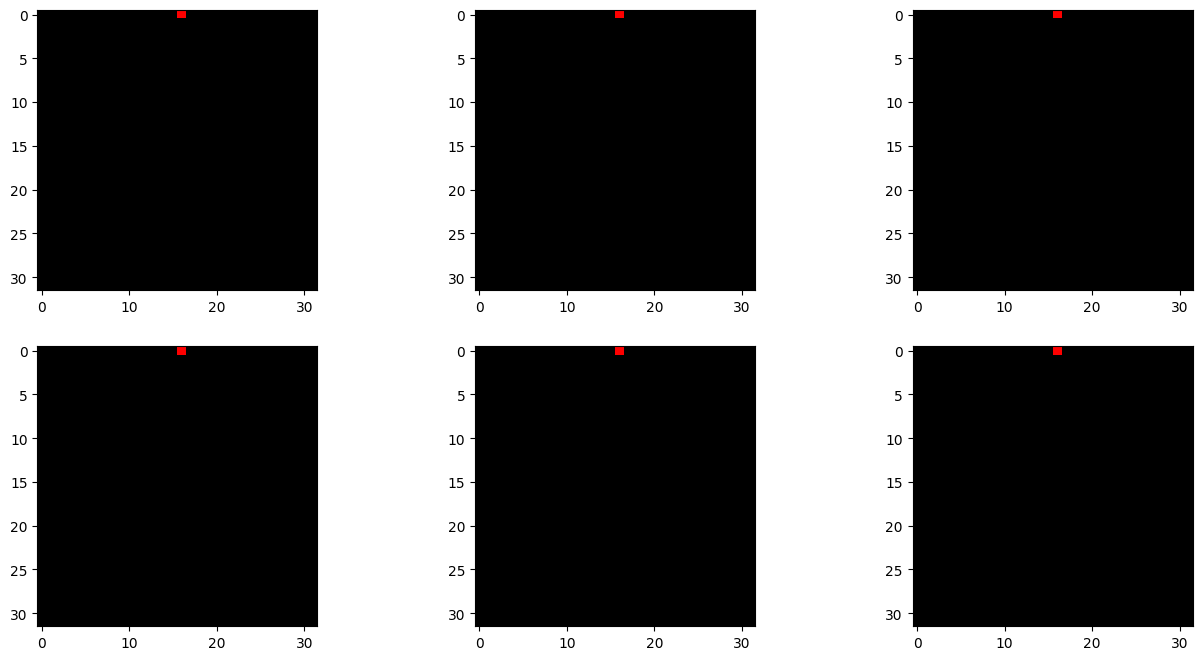

In [29]:
f, axarr = plt.subplots(2,3, figsize=(16,8))

for i in range(2):
    for j in range(3):
        rand = random_G_vector_input().unsqueeze(0)
        # print(rand.shape)

        inputs = torch.cat( (rand, label_tensor) , dim=1)
        output = G_model.forward( inputs).cpu()
        # convert output (batch, img_size) to (batch, 4, 32, 32)
        if channels == 4 or channels == 3:
            output = output.reshape((-1, channels, pixels, pixels))
            img = output.permute(0, 2, 3, 1).detach().numpy()#.reshape(pixels,pixels)
        elif channels == 1:
            output = output.reshape((-1, pixels, pixels))
            img = output.detach().numpy()

        # print(img.shape)
        # convert img to pil
        img = Image.fromarray((img * 255).astype(np.uint8)[0])
        # display the image
        # plt.imshow(img)
        axarr[i,j].imshow(img)#, interpolation='none', cmap='Blues'